In [105]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import re,os
from IPython.core.display import display, HTML

plt.rcParams['figure.figsize'] = (20,20)
plt.rcParams.update({'font.size': 22})

In [2]:
!ls -l data/HIPE2022/scoring.pkl

-rw-r--r-- 1 labusch users 915966 24. Mai 07:06 data/HIPE2022/scoring.pkl


In [3]:
df = pd.read_pickle('data/HIPE2022/scoring.pkl').\
    drop(columns=['F1_std', 'P_std', 'R_std', 'TP', 'FP', 'FN', 'Label'])

In [4]:
df_test = df.loc[df.kind.str.startswith('test')].drop(columns=['kind'])
df_dev  = df.loc[df.kind.str.startswith('dev')].drop(columns=['kind'])

In [5]:
df_merge =\
    df_dev.merge(df_test, left_on=['Evaluation', 'dataset', 'lang', 'max_dist', 'max_candidates', 'threshold'],
            right_on=['Evaluation', 'dataset', 'lang', 'max_dist', 'max_candidates', 'threshold'],
            suffixes=('_dev', '_test'))

df_merge = df_merge[['Evaluation', 'dataset','lang','max_dist','max_candidates', 'threshold','P_dev','P_test','R_dev','R_test','F1_dev','F1_test']]

In [6]:
df_merge.Evaluation.value_counts()

NEL-LIT-macro_doc-strict-eval-TIME-ALL-LED-ALL-@5    240
NEL-LIT-micro-strict-eval-TIME-ALL-LED-ALL-@5        240
NEL-LIT-macro_doc-strict-eval-TIME-ALL-LED-ALL-@1    240
NEL-LIT-micro-fuzzy-eval-TIME-ALL-LED-ALL-@1         240
NEL-LIT-micro-strict-eval-TIME-ALL-LED-ALL-@3        240
NEL-LIT-micro-fuzzy-eval-TIME-ALL-LED-ALL-@3         240
NEL-LIT-macro_doc-fuzzy-eval-TIME-ALL-LED-ALL-@1     240
NEL-LIT-macro_doc-fuzzy-eval-TIME-ALL-LED-ALL-@5     240
NEL-LIT-micro-fuzzy-eval-TIME-ALL-LED-ALL-@5         240
NEL-LIT-macro_doc-fuzzy-eval-TIME-ALL-LED-ALL-@3     240
NEL-LIT-macro_doc-strict-eval-TIME-ALL-LED-ALL-@3    240
NEL-LIT-micro-strict-eval-TIME-ALL-LED-ALL-@1        240
Name: Evaluation, dtype: int64

In [107]:
for d, part in df_merge.groupby('dataset'):
    display(HTML(part.sort_values('F1_test', ascending=False).head(20).to_html(escape=False)))

,Evaluation,dataset,lang,max_dist,max_candidates,threshold,P_dev,P_test,R_dev,R_test,F1_dev,F1_test
633,NEL-LIT-micro-strict-eval-TIME-ALL-LED-ALL-@5,ajmc,de,0.13,50,0.3,0.752,0.804,0.412,0.389,0.532,0.525
632,NEL-LIT-micro-fuzzy-eval-TIME-ALL-LED-ALL-@5,ajmc,de,0.13,50,0.3,0.752,0.804,0.412,0.389,0.532,0.525
629,NEL-LIT-micro-strict-eval-TIME-ALL-LED-ALL-@3,ajmc,de,0.13,50,0.3,0.752,0.804,0.412,0.389,0.532,0.525
628,NEL-LIT-micro-fuzzy-eval-TIME-ALL-LED-ALL-@3,ajmc,de,0.13,50,0.3,0.752,0.804,0.412,0.389,0.532,0.525
2757,NEL-LIT-micro-strict-eval-TIME-ALL-LED-ALL-@5,ajmc,de,0.13,50,0.25,0.722,0.758,0.412,0.395,0.524,0.519
2753,NEL-LIT-micro-strict-eval-TIME-ALL-LED-ALL-@3,ajmc,de,0.13,50,0.25,0.722,0.758,0.412,0.395,0.524,0.519
2756,NEL-LIT-micro-fuzzy-eval-TIME-ALL-LED-ALL-@5,ajmc,de,0.13,50,0.25,0.722,0.758,0.412,0.395,0.524,0.519
2752,NEL-LIT-micro-fuzzy-eval-TIME-ALL-LED-ALL-@3,ajmc,de,0.13,50,0.25,0.722,0.758,0.412,0.395,0.524,0.519
625,NEL-LIT-micro-strict-eval-TIME-ALL-LED-ALL-@1,ajmc,de,0.13,50,0.3,0.752,0.793,0.412,0.384,0.532,0.518
2265,NEL-LIT-micro-strict-eval-TIME-ALL-LED-ALL-@5,ajmc,de,0.13,50,0.4,0.778,0.793,0.412,0.384,0.538,0.518


,Evaluation,dataset,lang,max_dist,max_candidates,threshold,P_dev,P_test,R_dev,R_test,F1_dev,F1_test
2177,NEL-LIT-micro-strict-eval-TIME-ALL-LED-ALL-@3,hipe2020,fr,0.13,50,0.2,0.724,0.721,0.530,0.525,0.612,0.608
2181,NEL-LIT-micro-strict-eval-TIME-ALL-LED-ALL-@5,hipe2020,fr,0.13,50,0.2,0.724,0.721,0.530,0.525,0.612,0.608
2176,NEL-LIT-micro-fuzzy-eval-TIME-ALL-LED-ALL-@3,hipe2020,fr,0.13,50,0.2,0.725,0.722,0.531,0.526,0.613,0.608
2180,NEL-LIT-micro-fuzzy-eval-TIME-ALL-LED-ALL-@5,hipe2020,fr,0.13,50,0.2,0.725,0.722,0.531,0.526,0.613,0.608
2372,NEL-LIT-micro-fuzzy-eval-TIME-ALL-LED-ALL-@5,hipe2020,fr,0.13,50,0.35,0.761,0.756,0.515,0.507,0.614,0.607
1156,NEL-LIT-micro-fuzzy-eval-TIME-ALL-LED-ALL-@3,hipe2020,fr,0.13,50,0.3,0.754,0.743,0.519,0.513,0.615,0.607
568,NEL-LIT-micro-fuzzy-eval-TIME-ALL-LED-ALL-@3,hipe2020,fr,0.13,50,0.25,0.733,0.733,0.525,0.518,0.612,0.607
572,NEL-LIT-micro-fuzzy-eval-TIME-ALL-LED-ALL-@5,hipe2020,fr,0.13,50,0.25,0.733,0.733,0.525,0.518,0.612,0.607
1160,NEL-LIT-micro-fuzzy-eval-TIME-ALL-LED-ALL-@5,hipe2020,fr,0.13,50,0.3,0.754,0.743,0.519,0.513,0.615,0.607
2368,NEL-LIT-micro-fuzzy-eval-TIME-ALL-LED-ALL-@3,hipe2020,fr,0.13,50,0.35,0.761,0.756,0.515,0.507,0.614,0.607


,Evaluation,dataset,lang,max_dist,max_candidates,threshold,P_dev,P_test,R_dev,R_test,F1_dev,F1_test
2072,NEL-LIT-macro_doc-fuzzy-eval-TIME-ALL-LED-ALL-@5,newseye,fr,0.05,25,0.4,0.678,0.647,0.446,0.359,0.534,0.455
2073,NEL-LIT-macro_doc-fuzzy-eval-TIME-ALL-LED-ALL-@5,newseye,fr,0.05,25,0.4,0.650,0.647,0.409,0.359,0.500,0.455
2065,NEL-LIT-macro_doc-fuzzy-eval-TIME-ALL-LED-ALL-@3,newseye,fr,0.05,25,0.4,0.650,0.647,0.409,0.359,0.500,0.455
2064,NEL-LIT-macro_doc-fuzzy-eval-TIME-ALL-LED-ALL-@3,newseye,fr,0.05,25,0.4,0.678,0.647,0.446,0.359,0.534,0.455
2074,NEL-LIT-macro_doc-strict-eval-TIME-ALL-LED-ALL-@5,newseye,fr,0.05,25,0.4,0.678,0.646,0.446,0.359,0.534,0.454
2288,NEL-LIT-micro-fuzzy-eval-TIME-ALL-LED-ALL-@3,newseye,de,0.05,25,0.25,0.545,0.545,0.361,0.389,0.434,0.454
2298,NEL-LIT-micro-strict-eval-TIME-ALL-LED-ALL-@5,newseye,de,0.05,25,0.25,0.545,0.545,0.361,0.389,0.434,0.454
2297,NEL-LIT-micro-fuzzy-eval-TIME-ALL-LED-ALL-@5,newseye,de,0.05,25,0.25,0.666,0.545,0.493,0.389,0.566,0.454
2296,NEL-LIT-micro-fuzzy-eval-TIME-ALL-LED-ALL-@5,newseye,de,0.05,25,0.25,0.545,0.545,0.361,0.389,0.434,0.454
2291,NEL-LIT-micro-strict-eval-TIME-ALL-LED-ALL-@3,newseye,de,0.05,25,0.25,0.666,0.545,0.493,0.389,0.566,0.454


,Evaluation,dataset,lang,max_dist,max_candidates,threshold,P_dev,P_test,R_dev,R_test,F1_dev,F1_test
2314,NEL-LIT-macro_doc-fuzzy-eval-TIME-ALL-LED-ALL-@5,sonar,de,0.05,25,0.15,0.713,0.674,0.570,0.539,0.631,0.594
2311,NEL-LIT-macro_doc-strict-eval-TIME-ALL-LED-ALL-@3,sonar,de,0.05,25,0.15,0.713,0.674,0.570,0.539,0.631,0.594
2310,NEL-LIT-macro_doc-fuzzy-eval-TIME-ALL-LED-ALL-@3,sonar,de,0.05,25,0.15,0.713,0.674,0.570,0.539,0.631,0.594
2315,NEL-LIT-macro_doc-strict-eval-TIME-ALL-LED-ALL-@5,sonar,de,0.05,25,0.15,0.713,0.674,0.570,0.539,0.631,0.594
1674,NEL-LIT-macro_doc-fuzzy-eval-TIME-ALL-LED-ALL-@3,sonar,de,0.05,25,0.25,0.744,0.712,0.538,0.516,0.620,0.591
1678,NEL-LIT-macro_doc-fuzzy-eval-TIME-ALL-LED-ALL-@5,sonar,de,0.05,25,0.25,0.744,0.712,0.538,0.516,0.620,0.591
1675,NEL-LIT-macro_doc-strict-eval-TIME-ALL-LED-ALL-@3,sonar,de,0.05,25,0.25,0.744,0.712,0.538,0.516,0.620,0.591
1679,NEL-LIT-macro_doc-strict-eval-TIME-ALL-LED-ALL-@5,sonar,de,0.05,25,0.25,0.744,0.712,0.538,0.516,0.620,0.591
1518,NEL-LIT-macro_doc-fuzzy-eval-TIME-ALL-LED-ALL-@3,sonar,de,0.05,25,0.2,0.729,0.684,0.559,0.525,0.629,0.590
1519,NEL-LIT-macro_doc-strict-eval-TIME-ALL-LED-ALL-@3,sonar,de,0.05,25,0.2,0.729,0.684,0.559,0.525,0.629,0.590


,Evaluation,dataset,lang,max_dist,max_candidates,threshold,P_dev,P_test,R_dev,R_test,F1_dev,F1_test
1474,NEL-LIT-macro_doc-fuzzy-eval-TIME-ALL-LED-ALL-@5,topres19th,en,0.13,50,0.3,0.794,0.825,0.577,0.597,0.654,0.686
1475,NEL-LIT-macro_doc-strict-eval-TIME-ALL-LED-ALL-@5,topres19th,en,0.13,50,0.3,0.794,0.825,0.577,0.597,0.654,0.686
1471,NEL-LIT-macro_doc-strict-eval-TIME-ALL-LED-ALL-@3,topres19th,en,0.13,50,0.3,0.794,0.825,0.577,0.597,0.654,0.686
1470,NEL-LIT-macro_doc-fuzzy-eval-TIME-ALL-LED-ALL-@3,topres19th,en,0.13,50,0.3,0.794,0.825,0.577,0.597,0.654,0.686
587,NEL-LIT-macro_doc-strict-eval-TIME-ALL-LED-ALL-@5,topres19th,en,0.13,50,0.25,0.772,0.813,0.580,0.599,0.655,0.685
582,NEL-LIT-macro_doc-fuzzy-eval-TIME-ALL-LED-ALL-@3,topres19th,en,0.13,50,0.25,0.772,0.813,0.580,0.599,0.655,0.685
583,NEL-LIT-macro_doc-strict-eval-TIME-ALL-LED-ALL-@3,topres19th,en,0.13,50,0.25,0.772,0.813,0.580,0.599,0.655,0.685
586,NEL-LIT-macro_doc-fuzzy-eval-TIME-ALL-LED-ALL-@5,topres19th,en,0.13,50,0.25,0.772,0.813,0.580,0.599,0.655,0.685
1466,NEL-LIT-macro_doc-fuzzy-eval-TIME-ALL-LED-ALL-@1,topres19th,en,0.13,50,0.3,0.794,0.822,0.577,0.595,0.654,0.684
1467,NEL-LIT-macro_doc-strict-eval-TIME-ALL-LED-ALL-@1,topres19th,en,0.13,50,0.3,0.794,0.822,0.577,0.595,0.654,0.684


In [8]:
best=[]
for (ds, la, ev), part in df_merge.groupby(['dataset', 'lang', 'Evaluation']):
    best.append(part.iloc[[part.F1_test.argmax()]])
best=pd.concat(best).reset_index(drop=True)

In [76]:
dataset_colors = {'ajmc':'r', 'hipe2020':'b', 'topres19th':'m', 'sonar':'g', 'newseye':'k'}

datasets = ['ajmc', 'hipe2020', 'newseye', 'topres19th', 'sonar']

languages = ['de', 'en', 'fr']

marker_type = { 'de': 's', 'en': 'x', 'fr':'^'}

def plot_dev_vs_test(metric, df_plot_all_, markersize=7, description='all'):
    
    df_plot_all = df_plot_all_.loc[df_plot_all_.Evaluation.str.contains('.*{}.*'.format(metric))].\
        set_index(['dataset', 'lang'], drop=True).sort_index()
    
    metric = df_plot_all.Evaluation.str[:-3].iloc[0]
    
    fig, axs = plt.subplots(3, 4, figsize=(24,20))
    
    fig.suptitle("Evaluation: {}".format(metric), fontsize=30)
    
    axs[0, 3].axis('off')
    axs[1, 3].axis('off')
    axs[2, 3].axis('off')
    
    for pos, num_results in enumerate([1,3, 5]):
        
        df_plot = df_plot_all.loc[df_plot_all.Evaluation.str.contains('@{}'.format(num_results))]
        
        for dpos, dataset in enumerate(datasets):

            for lang in languages:
                if (dataset, lang)  in df_plot.index:
                    axs[0,pos].plot(df_plot.loc[(dataset, lang)].F1_dev.astype(float), 
                                df_plot.loc[(dataset, lang)].F1_test.astype(float), 
                                '{}{}'.format(marker_type[lang], dataset_colors[dataset]), markersize=markersize,
                               label='{}:{}'.format(dataset, lang))
                    axs[0,pos].set_aspect('equal', 'box')
                    axs[0,pos].set_xlabel('F1 on dev set')
                    axs[0,0].set_ylabel('F1 on test set')
                    axs[0,pos].set_title('@{}'.format(num_results))

            for lang in languages:
                if (dataset, lang)  in df_plot.index:
                    axs[1,pos].plot(df_plot.loc[(dataset, lang)].P_dev.astype(float), 
                                df_plot.loc[(dataset, lang)].P_test.astype(float), 
                                '{}{}'.format(marker_type[lang], dataset_colors[dataset]), markersize=markersize)
                    axs[1,pos].set_aspect('equal', 'box')
                    axs[1,pos].set_xlabel('P on dev set')
                    axs[1,0].set_ylabel('P on test set')

            for lang in languages:
                if (dataset, lang)  in df_plot.index:
                    axs[2,pos].plot(df_plot.loc[(dataset, lang)].R_dev.astype(float), 
                                df_plot.loc[(dataset, lang)].R_test.astype(float), 
                                '{}{}'.format(marker_type[lang], dataset_colors[dataset]), markersize=markersize,
                                   label='{}:{}'.format(lang, dataset))
                    axs[2,pos].set_aspect('equal', 'box')
                    axs[2,pos].set_xlabel('R on dev set')
                    axs[2,0].set_ylabel('R on test set')
    
    axs[0, 2].legend(loc='center left', bbox_to_anchor=(1.3, 0.5), frameon=False)
    
    for x in range(0,3):
        for y in range(0,3):
            axs[x,y].plot([0, 1], [0, 1], transform=axs[x,y].transAxes, ls='--', c='k')
                
    #fig.tight_layout()
    
    fig.savefig('{}-dev_vs_test_{}.pdf'.format(description, metric))
    
    return fig

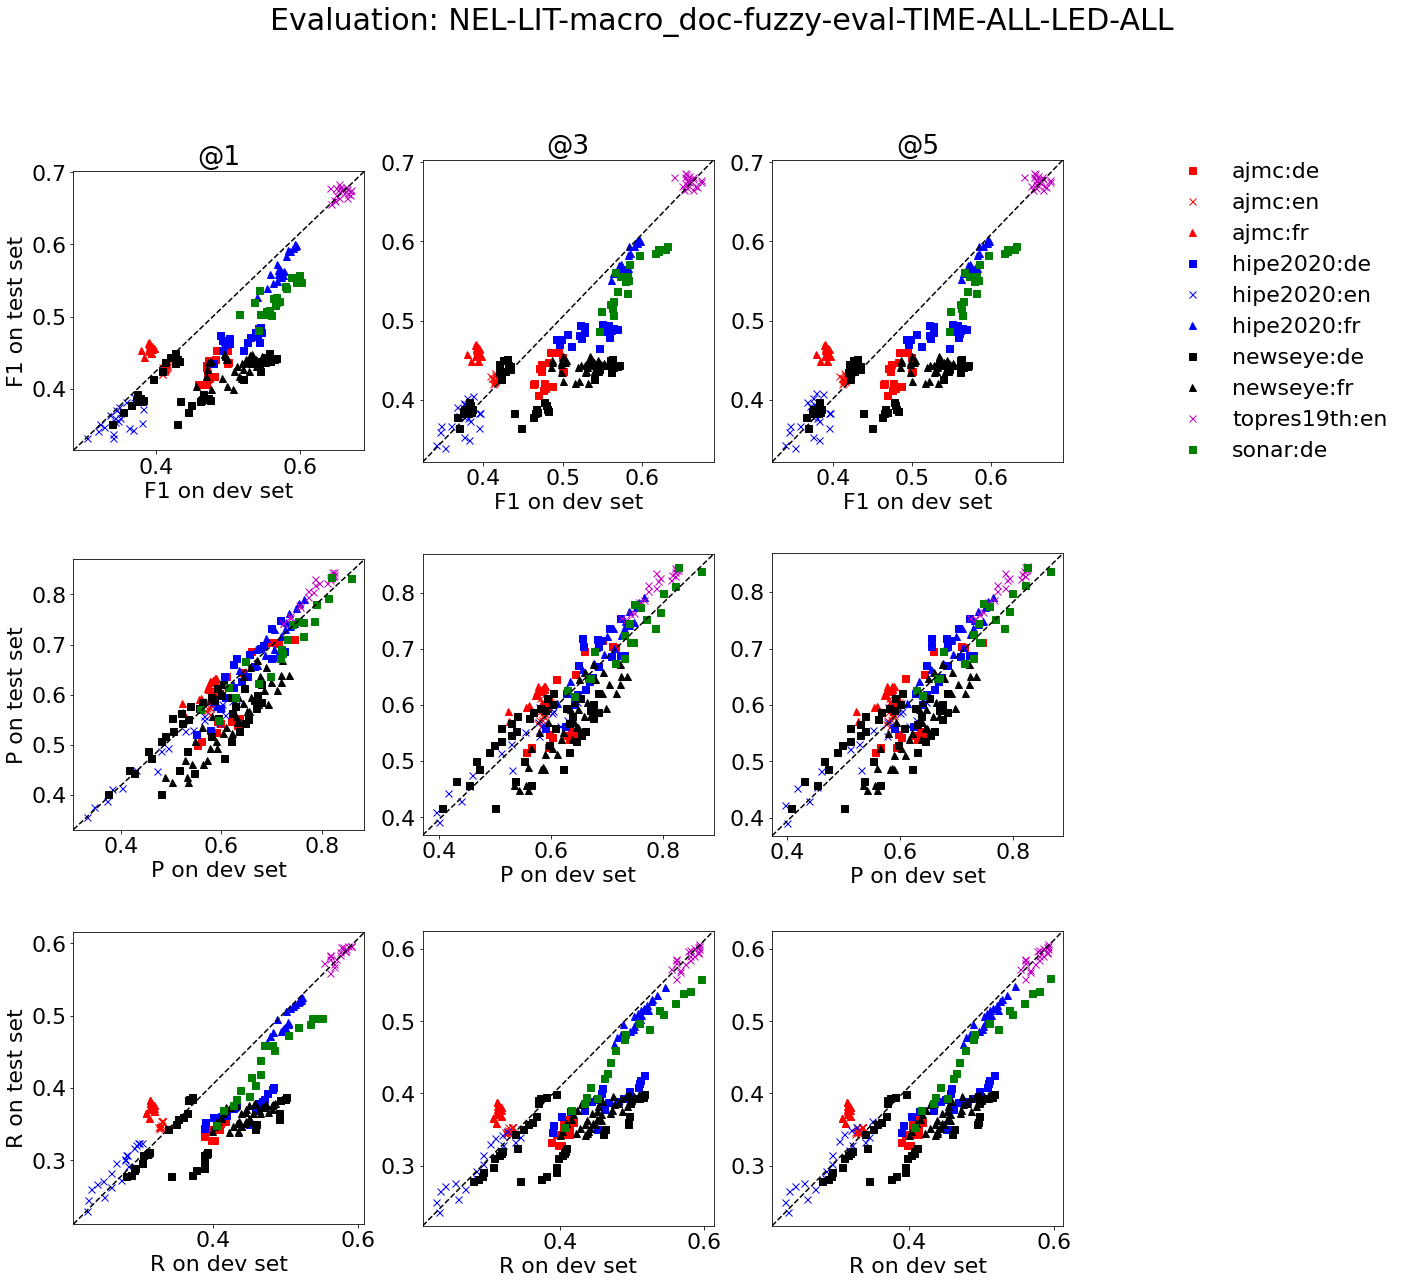

In [77]:
fig = plot_dev_vs_test('macro_doc-fuzzy', df_merge)

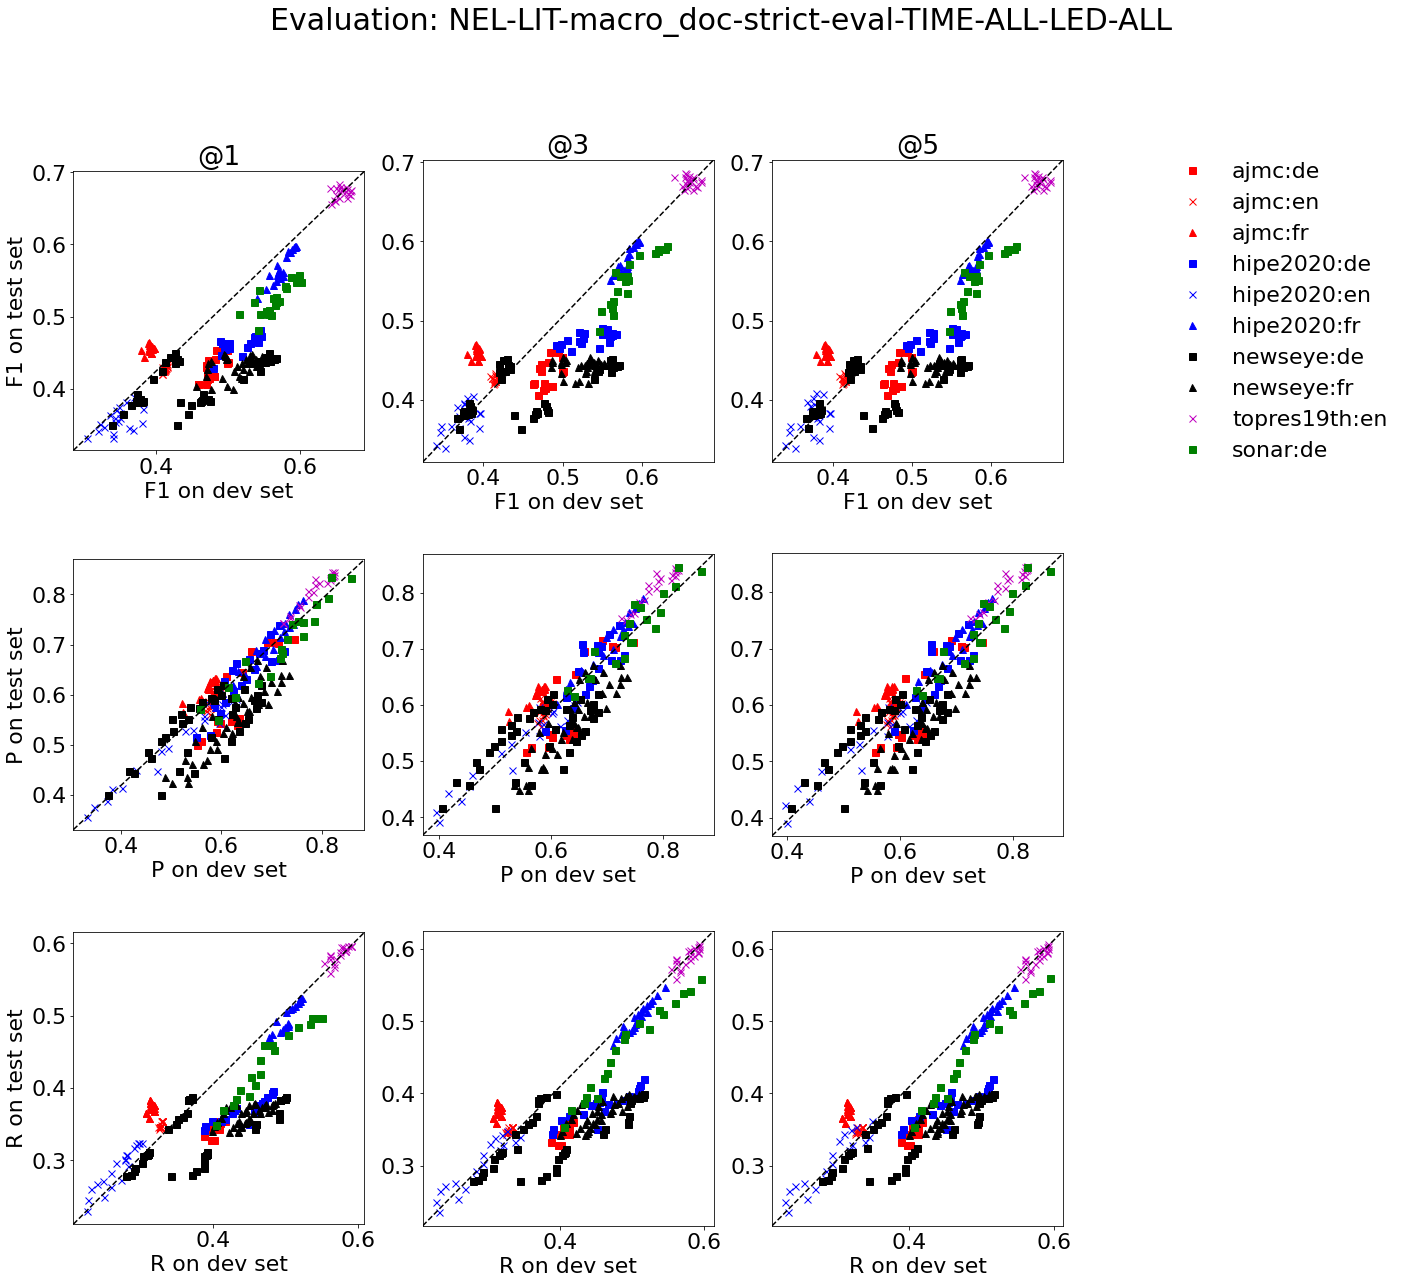

In [78]:
fig=plot_dev_vs_test('macro_doc-strict', df_merge)

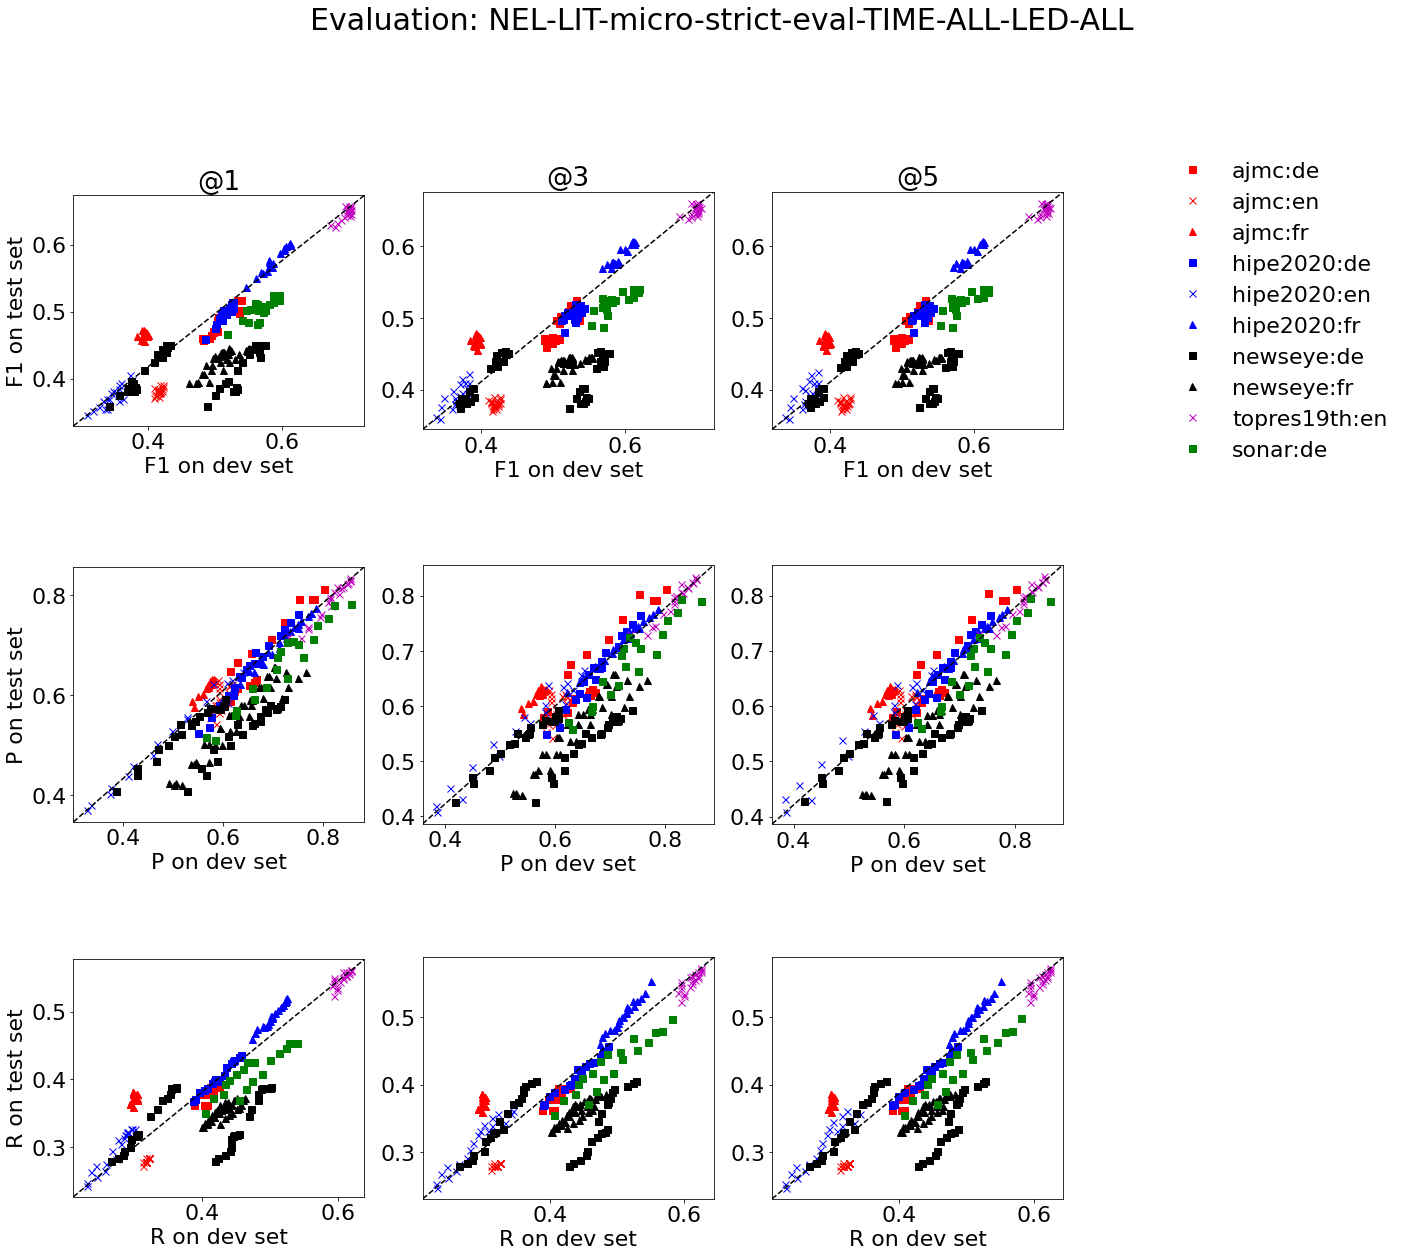

In [79]:
fig=plot_dev_vs_test('micro-strict', df_merge)

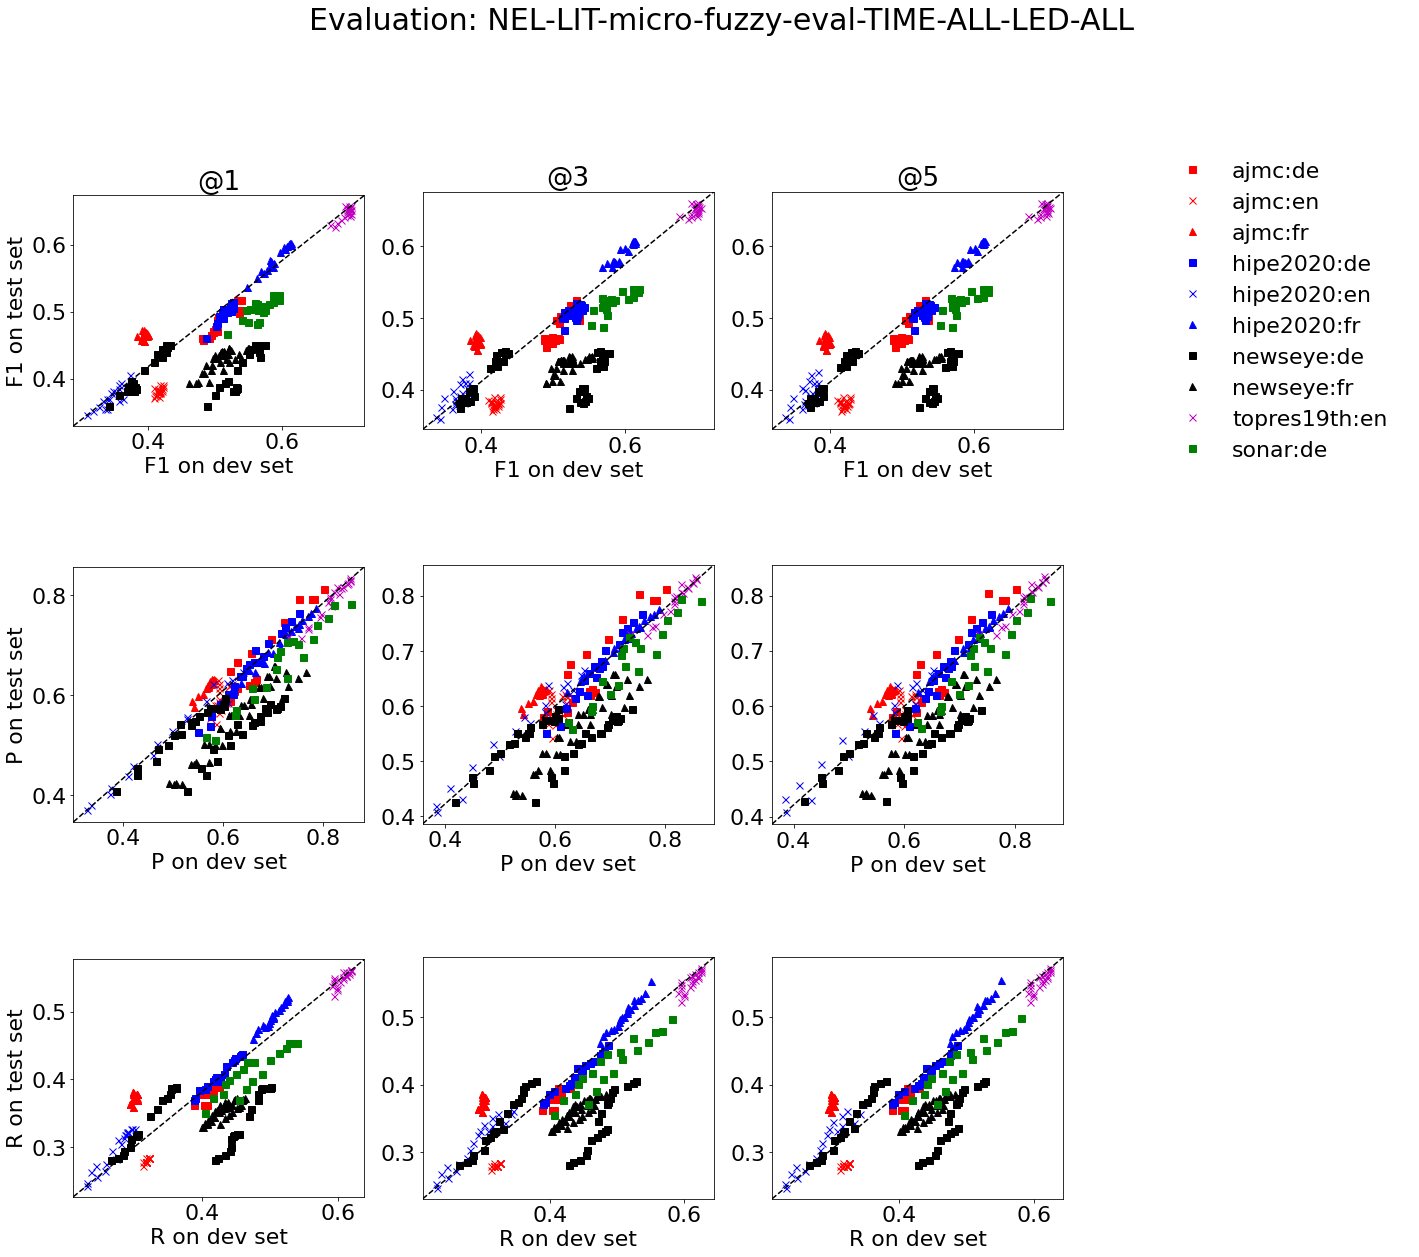

In [80]:
fig=plot_dev_vs_test('micro-fuzzy', df_merge)

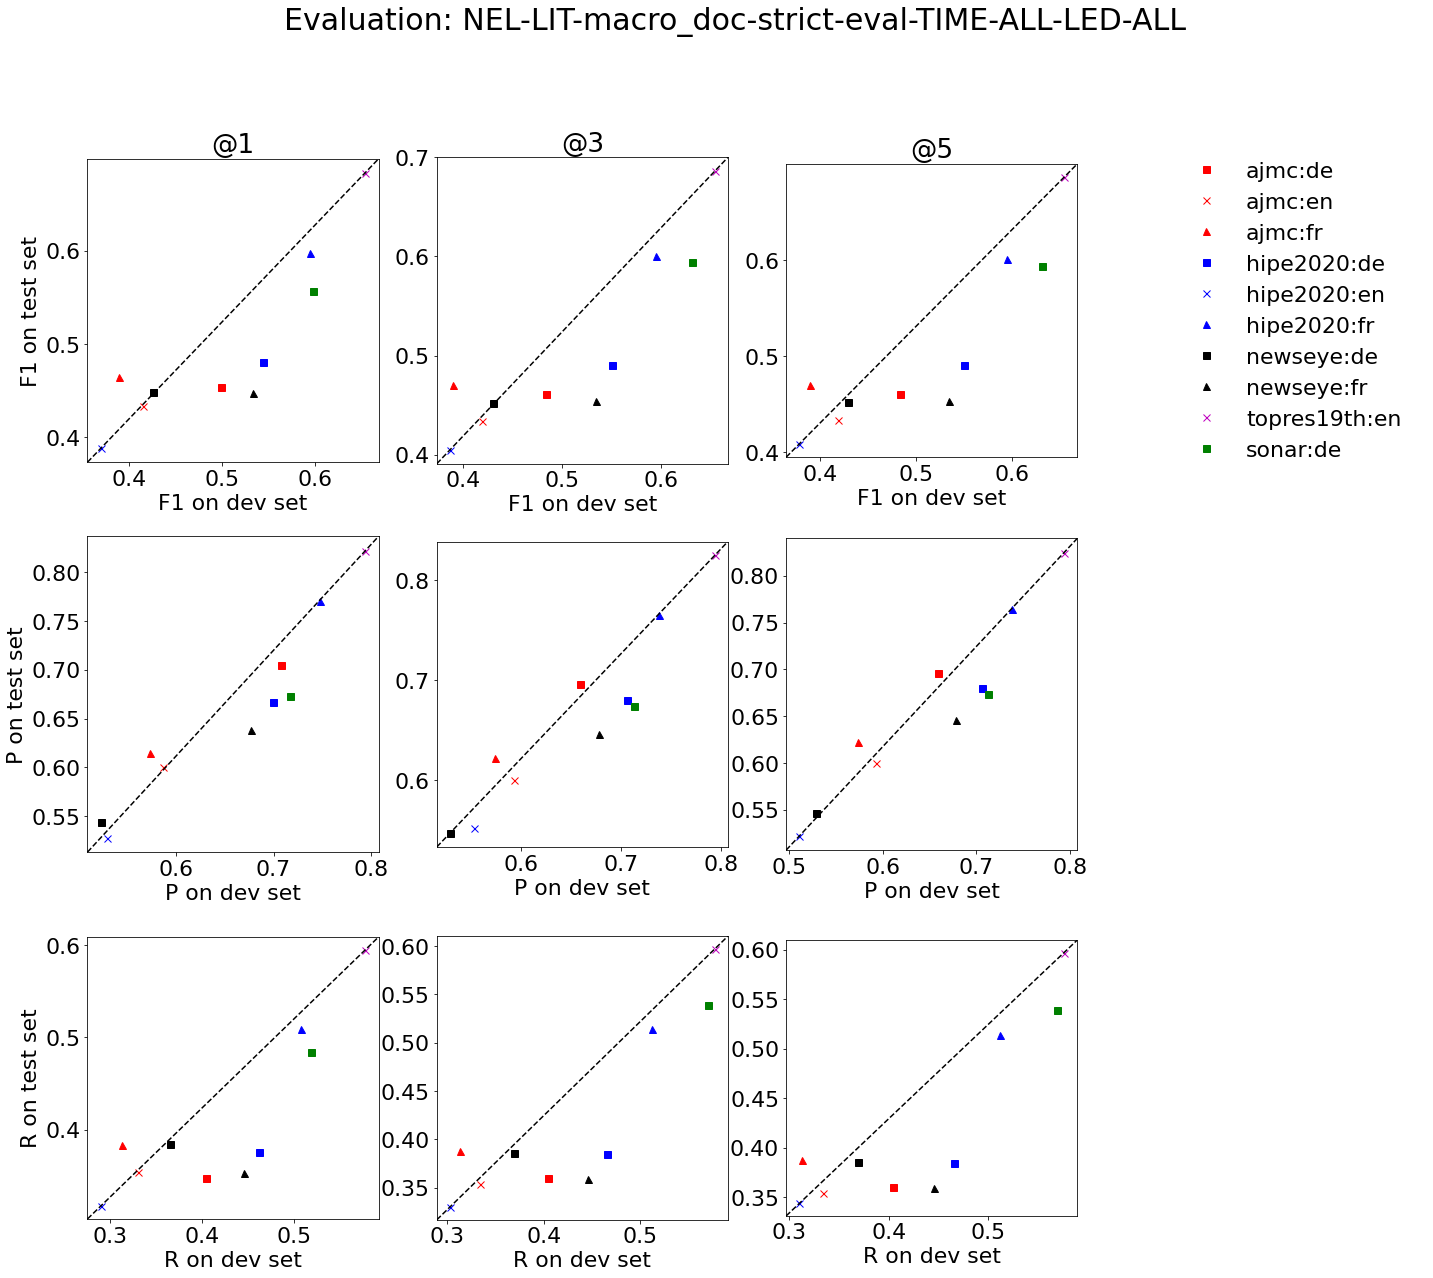

In [81]:
fig=plot_dev_vs_test('macro_doc-strict', best, description='best')

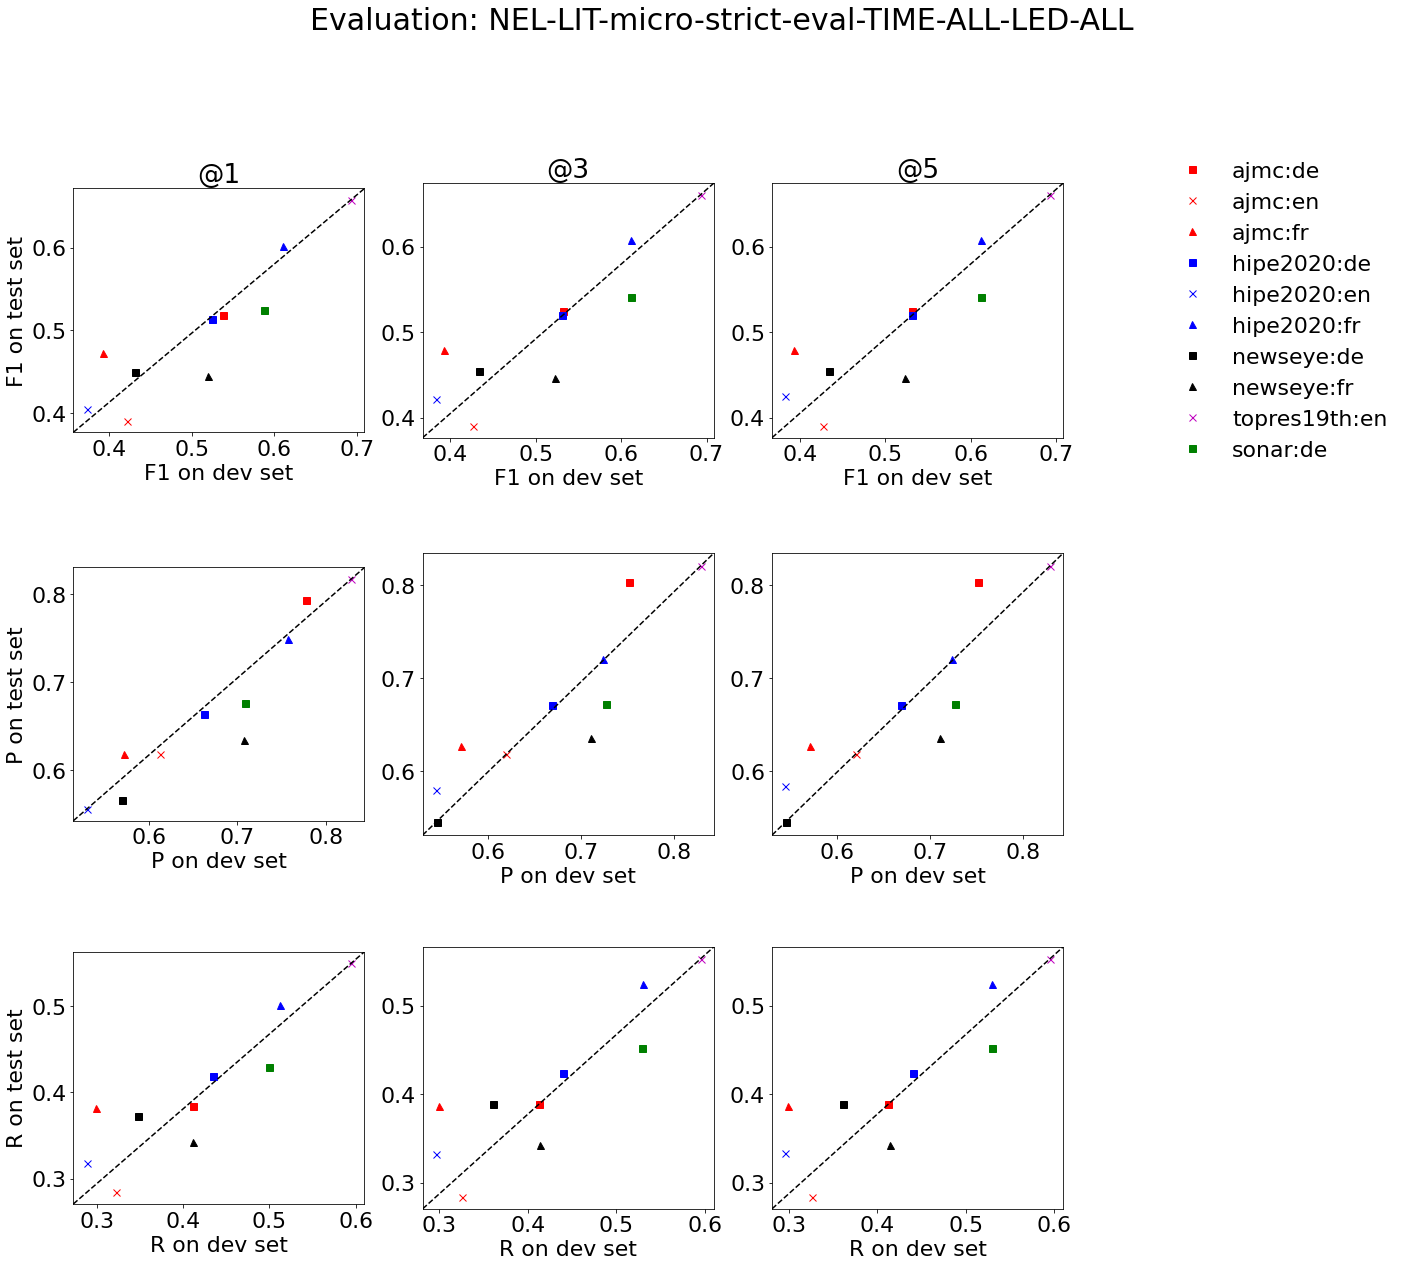

In [82]:
fig=plot_dev_vs_test('micro-strict', best, description='best')

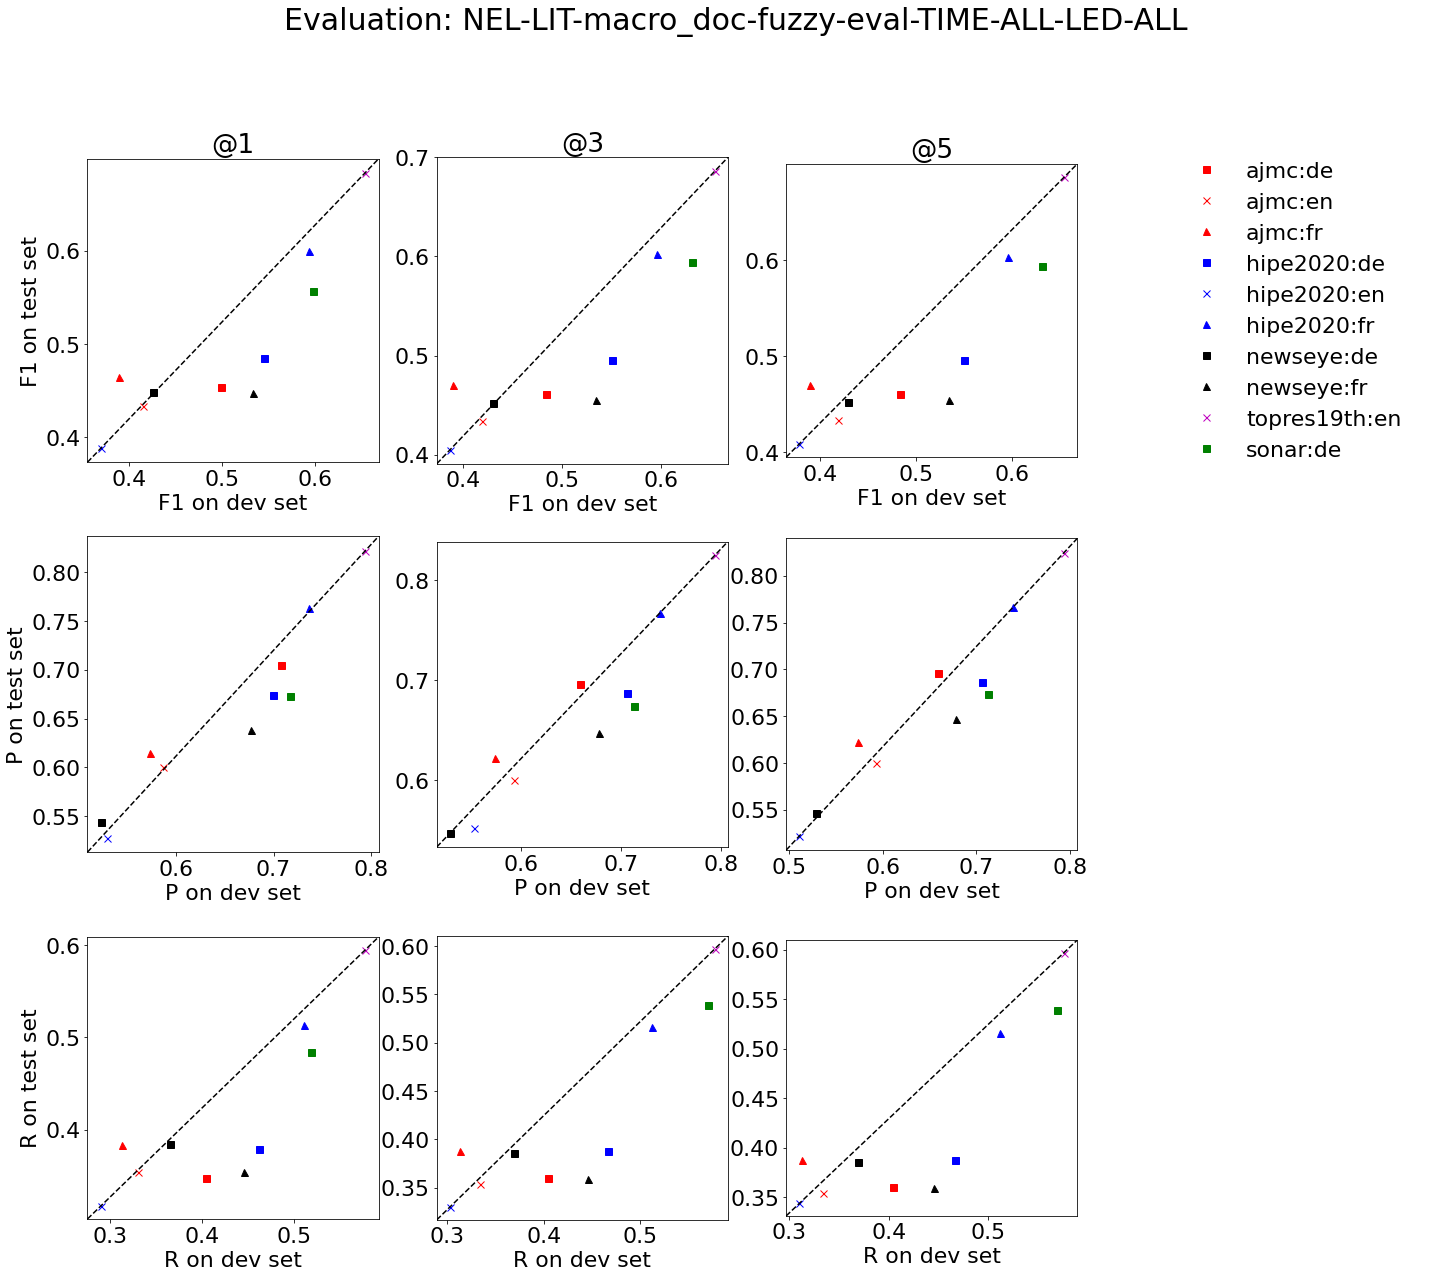

In [83]:
fig=plot_dev_vs_test('macro_doc-fuzzy', best, description='best')

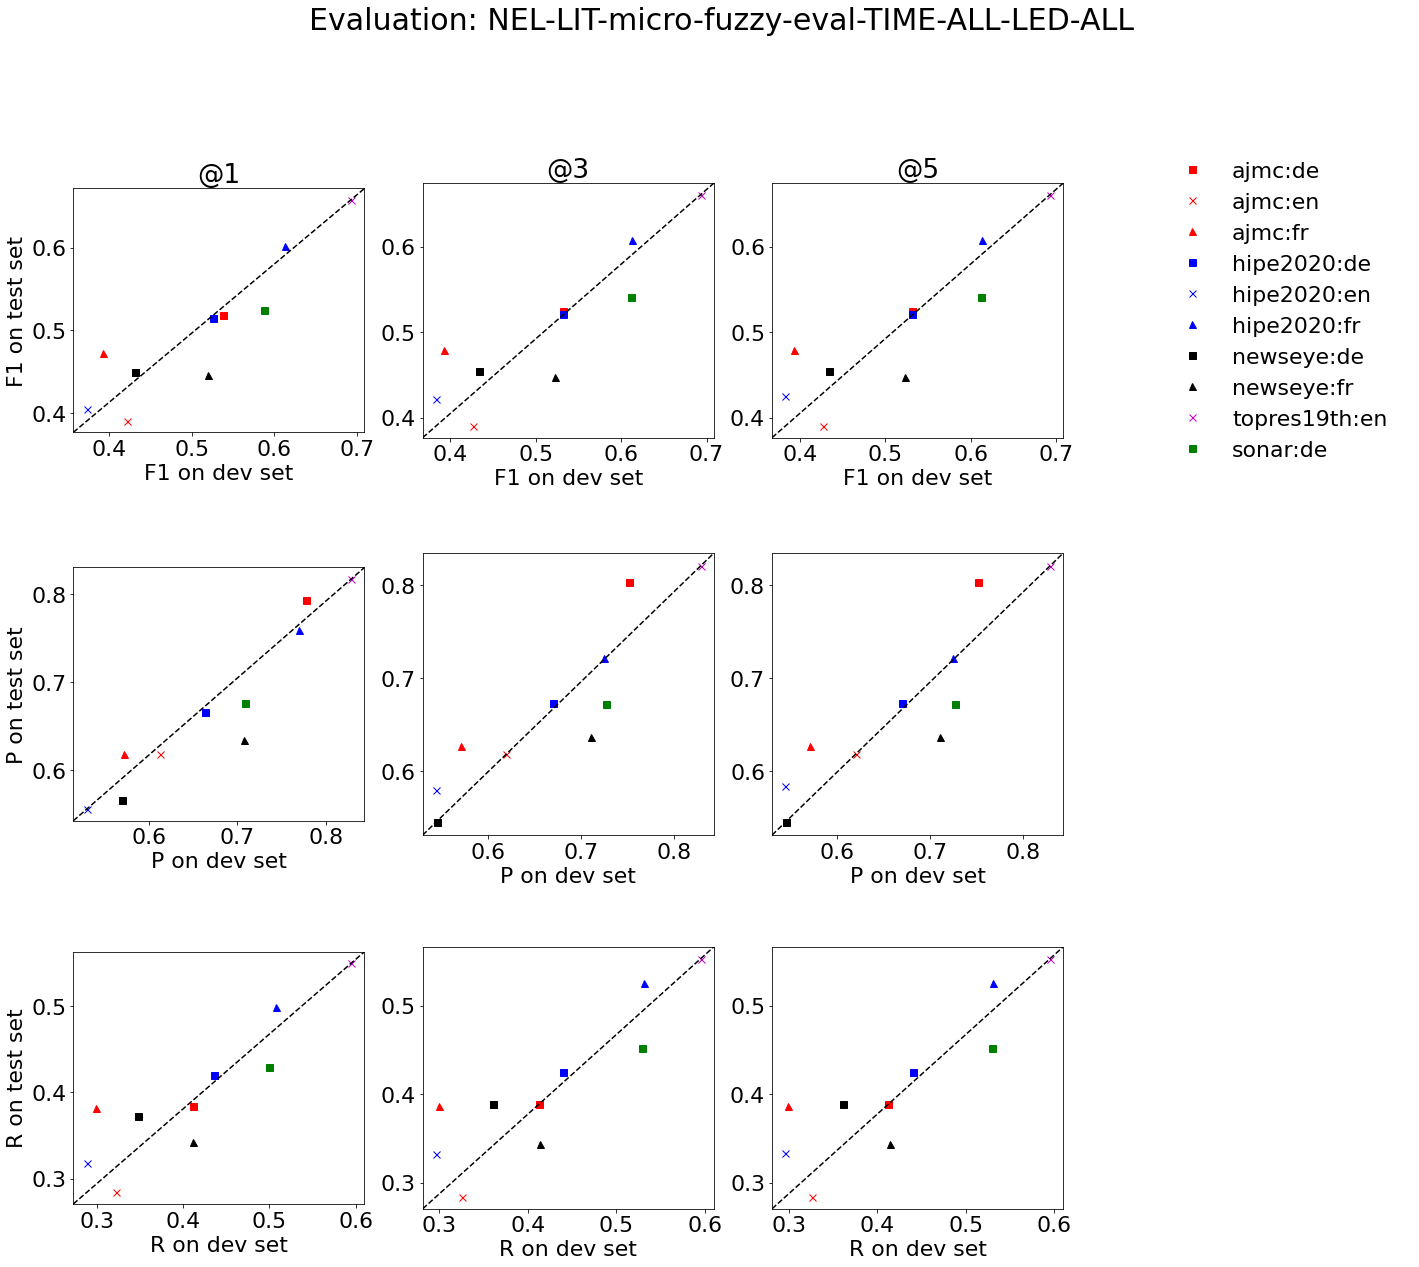

In [84]:
fig=plot_dev_vs_test('micro-fuzzy', best, description='best')

In [85]:
def selection_table(metric):

    df_02 = df_merge.loc[df_merge.threshold.astype(float)==0.2]
    df_02_best=[]
    for (ds, la, ev), part in df_02.groupby(['dataset', 'lang', 'Evaluation']):
        df_02_best.append(part.iloc[[part.F1_dev.argmax()]])
    df_02_best=pd.concat(df_02_best).reset_index(drop=True)
    best_compare = best.merge(df_02_best[['dataset', 'lang', 'Evaluation', 'F1_test', 'threshold', 'max_dist', 
                                          'max_candidates']], 
                              on=['dataset', 'lang', 'Evaluation'], 
                              suffixes=('', '_02'))

    sel = best_compare.loc[best_compare.Evaluation.str.contains('.*{}.*@1'.format(metric))].drop(columns=['Evaluation', 'P_dev', 'P_test', 'R_dev', 'R_test']).reset_index(drop=True)
    
    sel.to_latex('{}-selection.tex'.format(metric))
    
    return sel

In [92]:
selection_table('macro_doc-strict')

,dataset,lang,max_dist,max_candidates,threshold,F1_dev,F1_test,F1_test_02,threshold_02,max_dist_02,max_candidates_02
0,ajmc,de,0.13,50,0.35,0.499,0.454,0.441,0.2,0.13,50
1,ajmc,en,0.13,50,0.35,0.415,0.434,0.429,0.2,0.13,50
2,ajmc,fr,0.13,50,0.15,0.390,0.465,0.459,0.2,0.05,25
3,hipe2020,de,0.05,25,0.4,0.544,0.481,0.472,0.2,0.05,25
4,hipe2020,en,0.13,50,0.25,0.370,0.388,0.382,0.2,0.13,50
5,hipe2020,fr,0.13,50,0.4,0.595,0.598,0.589,0.2,0.13,50
6,newseye,de,0.05,25,0.25,0.426,0.449,0.444,0.2,0.05,25
7,newseye,fr,0.05,25,0.4,0.533,0.448,0.431,0.2,0.13,50
8,sonar,de,0.05,25,0.25,0.598,0.557,0.548,0.2,0.05,25
9,topres19th,en,0.13,50,0.3,0.654,0.684,0.677,0.2,0.13,50


In [93]:
selection_table('macro_doc-fuzzy')

,dataset,lang,max_dist,max_candidates,threshold,F1_dev,F1_test,F1_test_02,threshold_02,max_dist_02,max_candidates_02
0,ajmc,de,0.13,50,0.35,0.499,0.454,0.441,0.2,0.13,50
1,ajmc,en,0.13,50,0.35,0.415,0.434,0.429,0.2,0.13,50
2,ajmc,fr,0.13,50,0.15,0.390,0.465,0.459,0.2,0.05,25
3,hipe2020,de,0.05,25,0.4,0.545,0.485,0.479,0.2,0.05,25
4,hipe2020,en,0.13,50,0.25,0.370,0.388,0.382,0.2,0.13,50
5,hipe2020,fr,0.13,50,0.35,0.593,0.600,0.591,0.2,0.13,50
6,newseye,de,0.05,25,0.25,0.426,0.449,0.444,0.2,0.05,25
7,newseye,fr,0.05,25,0.4,0.533,0.448,0.431,0.2,0.13,50
8,sonar,de,0.05,25,0.25,0.598,0.557,0.548,0.2,0.05,25
9,topres19th,en,0.13,50,0.3,0.654,0.684,0.677,0.2,0.13,50


In [94]:
selection_table('micro-fuzzy')

,dataset,lang,max_dist,max_candidates,threshold,F1_dev,F1_test,F1_test_02,threshold_02,max_dist_02,max_candidates_02
0,ajmc,de,0.13,50,0.35,0.538,0.518,0.503,0.2,0.13,50
1,ajmc,en,0.13,50,0.35,0.422,0.390,0.381,0.2,0.13,50
2,ajmc,fr,0.13,50,0.15,0.393,0.473,0.470,0.2,0.05,25
3,hipe2020,de,0.05,25,0.4,0.526,0.515,0.506,0.2,0.05,25
4,hipe2020,en,0.13,50,0.25,0.373,0.405,0.393,0.2,0.13,50
5,hipe2020,fr,0.13,50,0.4,0.613,0.602,0.596,0.2,0.13,50
6,newseye,de,0.05,25,0.35,0.432,0.450,0.444,0.2,0.05,25
7,newseye,fr,0.13,50,0.45,0.520,0.446,0.430,0.2,0.13,50
8,sonar,de,0.05,25,0.3,0.587,0.525,0.517,0.2,0.05,25
9,topres19th,en,0.13,50,0.35,0.693,0.658,0.651,0.2,0.13,50


In [95]:
selection_table('micro-strict')

,dataset,lang,max_dist,max_candidates,threshold,F1_dev,F1_test,F1_test_02,threshold_02,max_dist_02,max_candidates_02
0,ajmc,de,0.13,50,0.35,0.538,0.518,0.503,0.2,0.13,50
1,ajmc,en,0.13,50,0.35,0.422,0.390,0.381,0.2,0.13,50
2,ajmc,fr,0.13,50,0.15,0.393,0.473,0.470,0.2,0.05,25
3,hipe2020,de,0.05,25,0.4,0.525,0.514,0.504,0.2,0.05,25
4,hipe2020,en,0.13,50,0.25,0.373,0.405,0.393,0.2,0.13,50
5,hipe2020,fr,0.13,50,0.35,0.611,0.602,0.595,0.2,0.13,50
6,newseye,de,0.05,25,0.35,0.432,0.450,0.444,0.2,0.05,25
7,newseye,fr,0.13,50,0.45,0.520,0.445,0.430,0.2,0.13,50
8,sonar,de,0.05,25,0.3,0.587,0.525,0.517,0.2,0.05,25
9,topres19th,en,0.13,50,0.35,0.693,0.658,0.651,0.2,0.13,50


In [87]:
def plot_lookup_influence(metric, df_test_):
    
    df_test =df_test_.loc[df_test_.Evaluation.str.contains('.*{}.*'.format(metric))]
    
    fig, axs = plt.subplots(3,4, figsize=(24,24))
    
    metric = df_test.Evaluation.str[:-3].iloc[0]
    
    fig.suptitle("Evaluation: {}".format(metric), fontsize=30)
    
    for pos, num_results in enumerate([1,3,5]):
        
        for lang_pos, lang in enumerate(languages):

            for dataset in datasets:
                tmp = df_test.loc[df_test.dataset == dataset]
                tmp = tmp.loc[(tmp.lang==lang) & tmp.Evaluation.str.contains('@{}'.format(num_results))]

                cand_max_25 = tmp.loc[tmp.max_candidates.astype(float)==25]
                cand_max_50 = tmp.loc[tmp.max_candidates.astype(float)==50]

                axs[lang_pos,pos].plot(cand_max_25.P, cand_max_25.R, 'o{}'.format(dataset_colors[dataset]),
                                      markersize=7, label="{}\n".format(dataset) +"$max_{cand}$=25" + "\n" + "$\Delta_l$=0.05" )
                axs[lang_pos,pos].plot(cand_max_50.P, cand_max_50.R, 'x{}'.format(dataset_colors[dataset]),
                                      markersize=7, label="{}\n".format(dataset) +"$max_{cand}$=50" + "\n" + "$\Delta_l$=0.13" )
                
                if lang_pos==2:
                    axs[lang_pos,pos].set_xlabel('Precision')
                if pos == 0: 
                    axs[lang_pos,pos].set_ylabel('Recall')
                axs[lang_pos,pos].set_title('{}: @{}'.format(lang, num_results))
                
    axs[0, 3].axis('off')
    axs[1, 3].axis('off')
    axs[2, 3].axis('off')
    
    axs[0, 2].legend(loc='center left', bbox_to_anchor=(1.3, 0), frameon=False)
    
    fig.savefig('lookup-influence_{}.pdf'.format(metric))

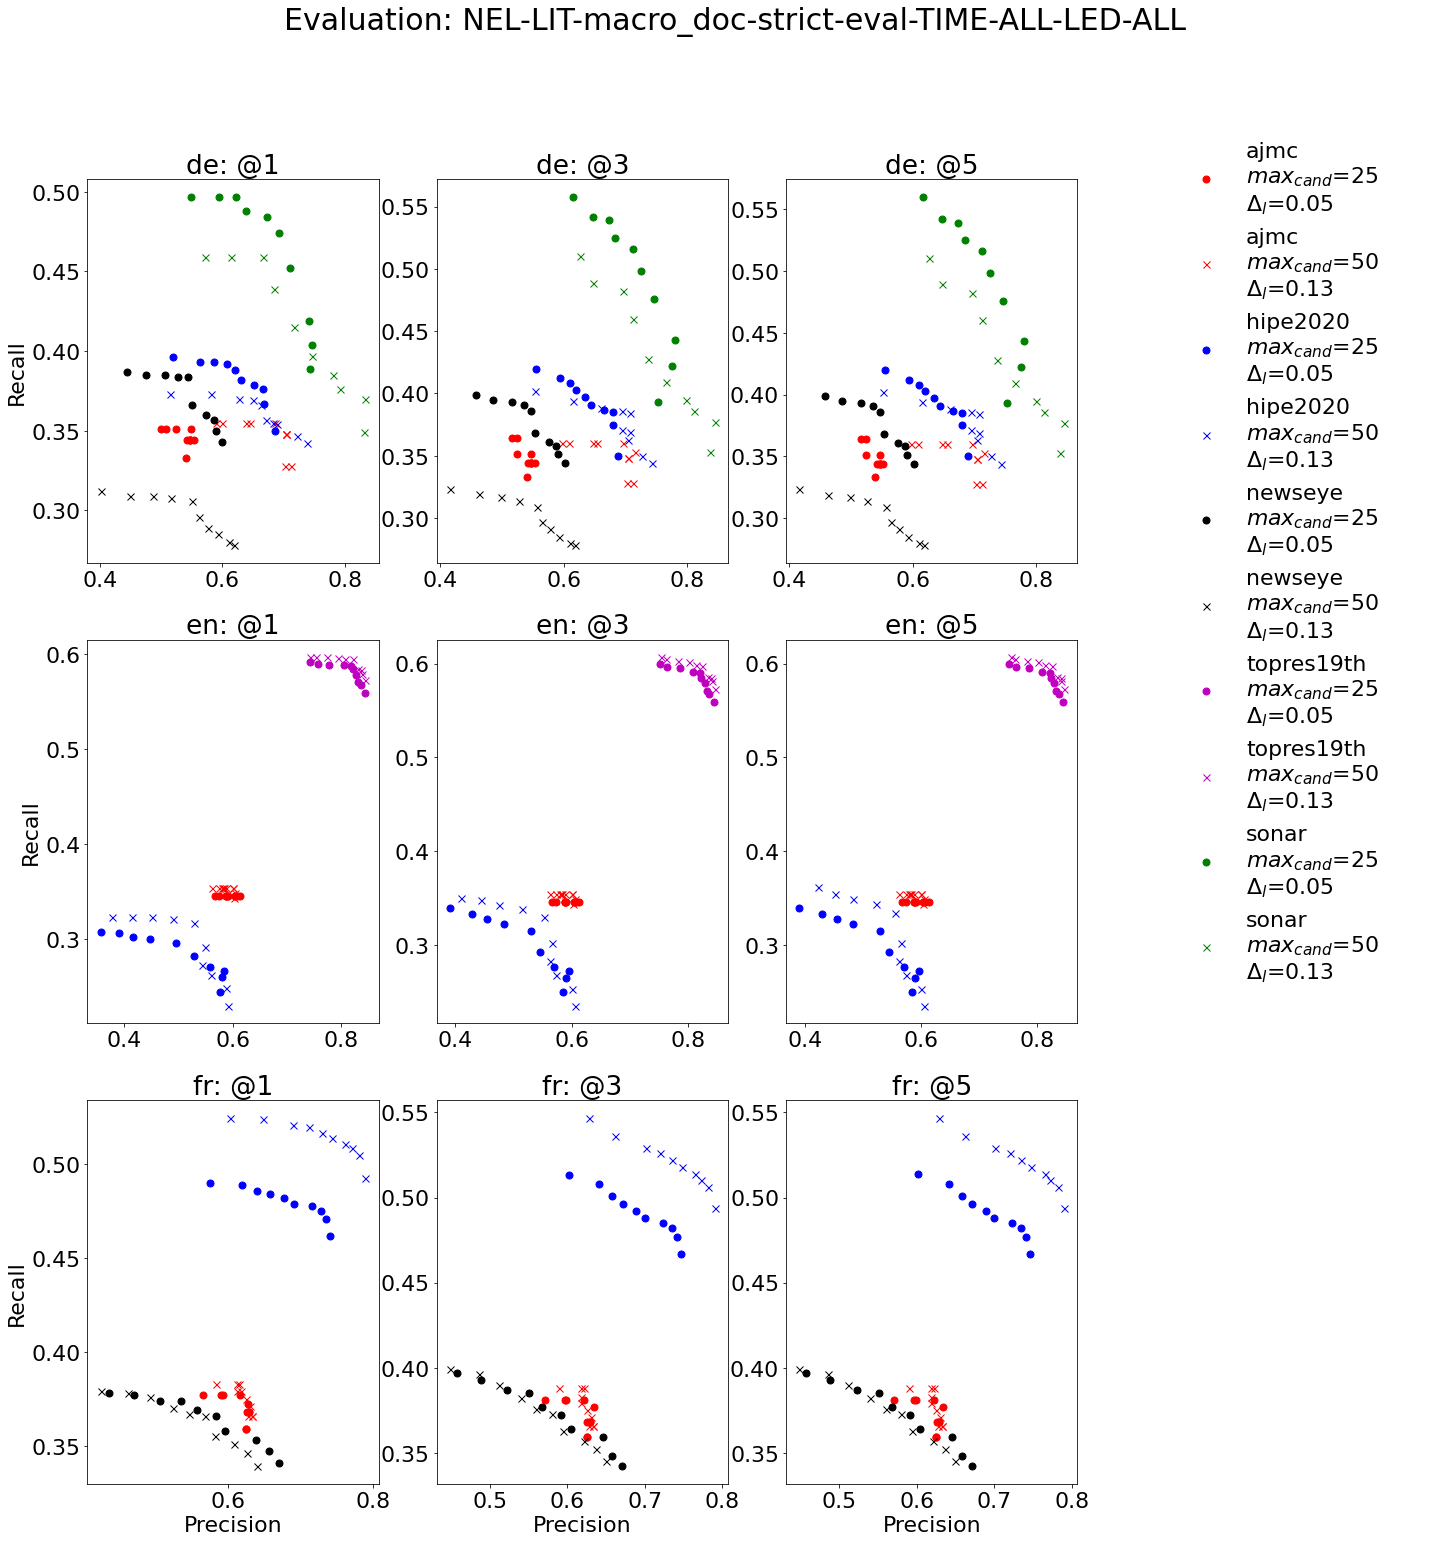

In [88]:
plot_lookup_influence('macro_doc-strict', df_test)

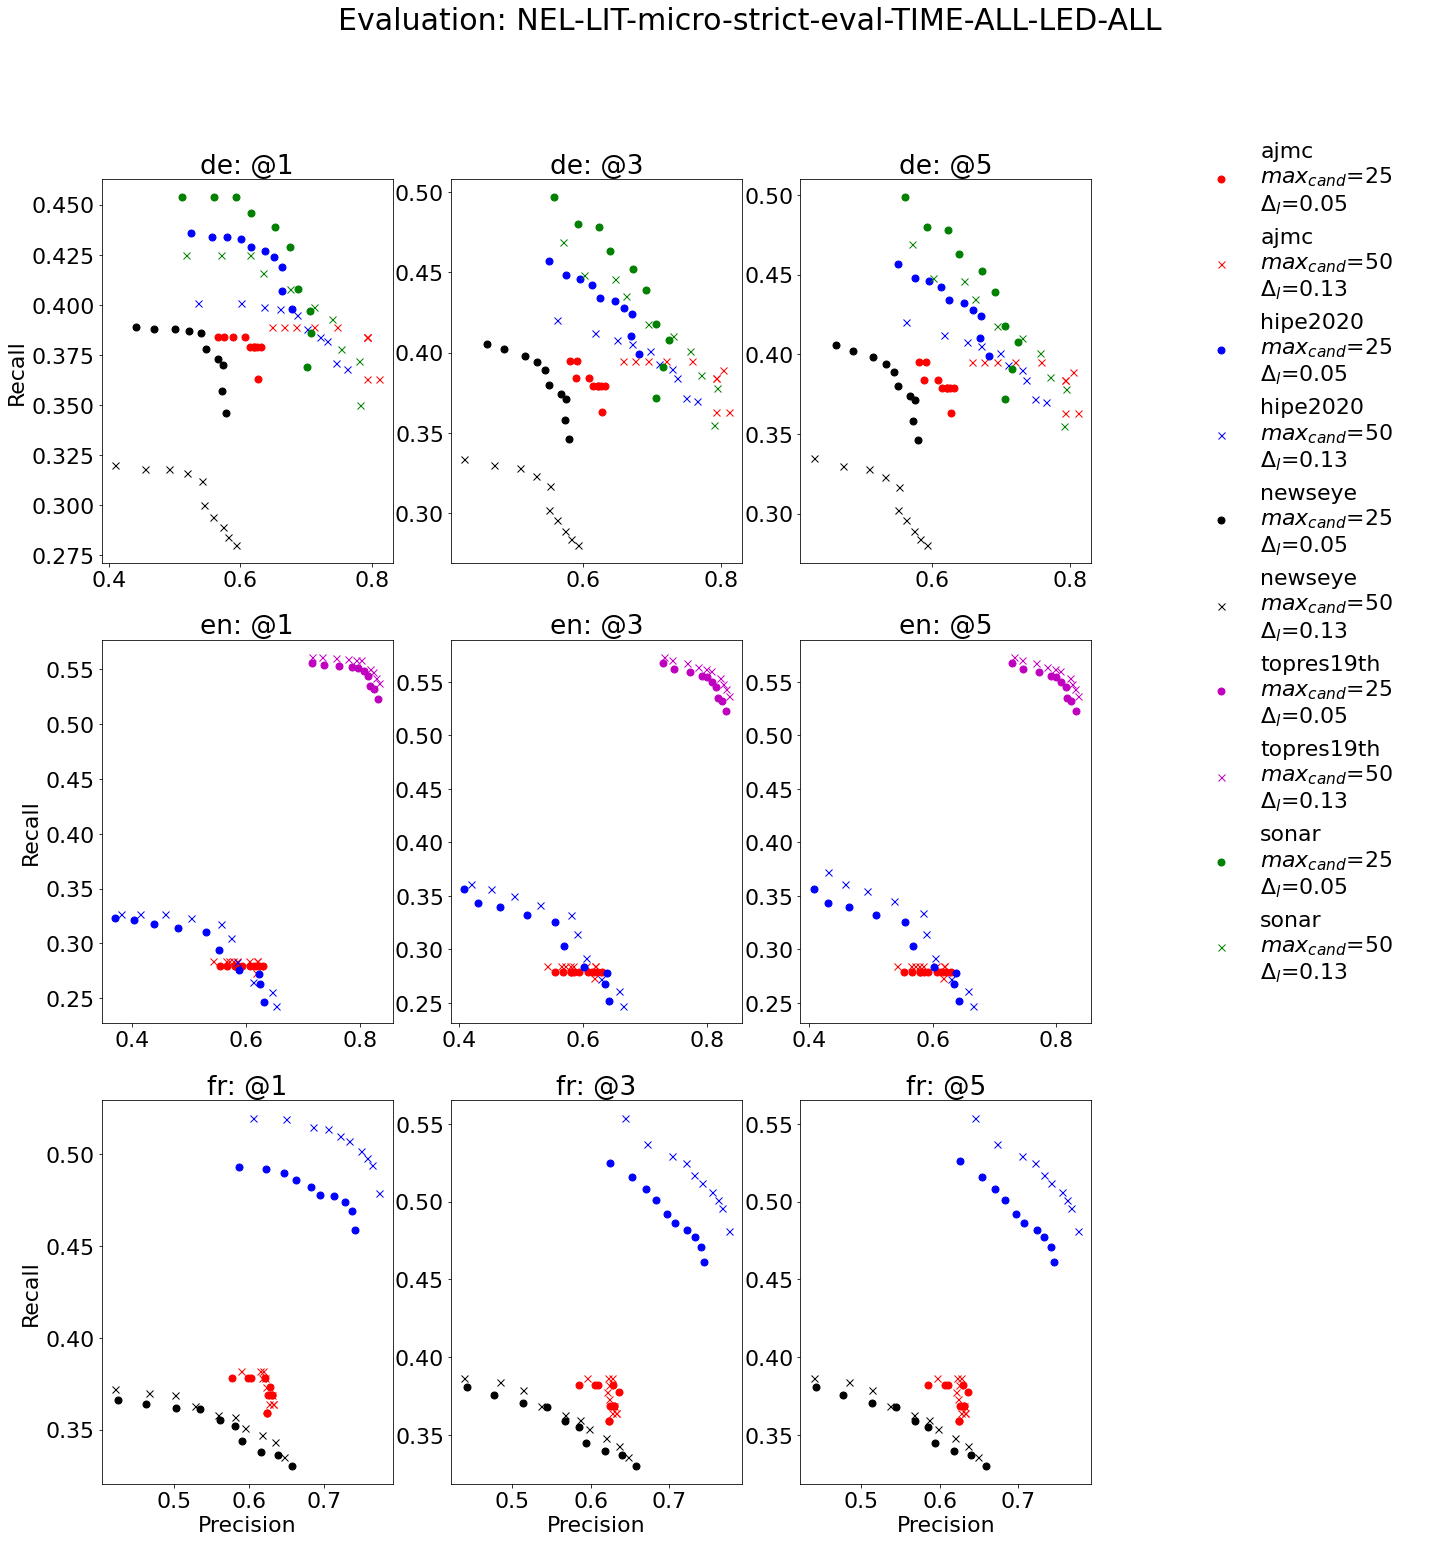

In [89]:
plot_lookup_influence('micro-strict', df_test)

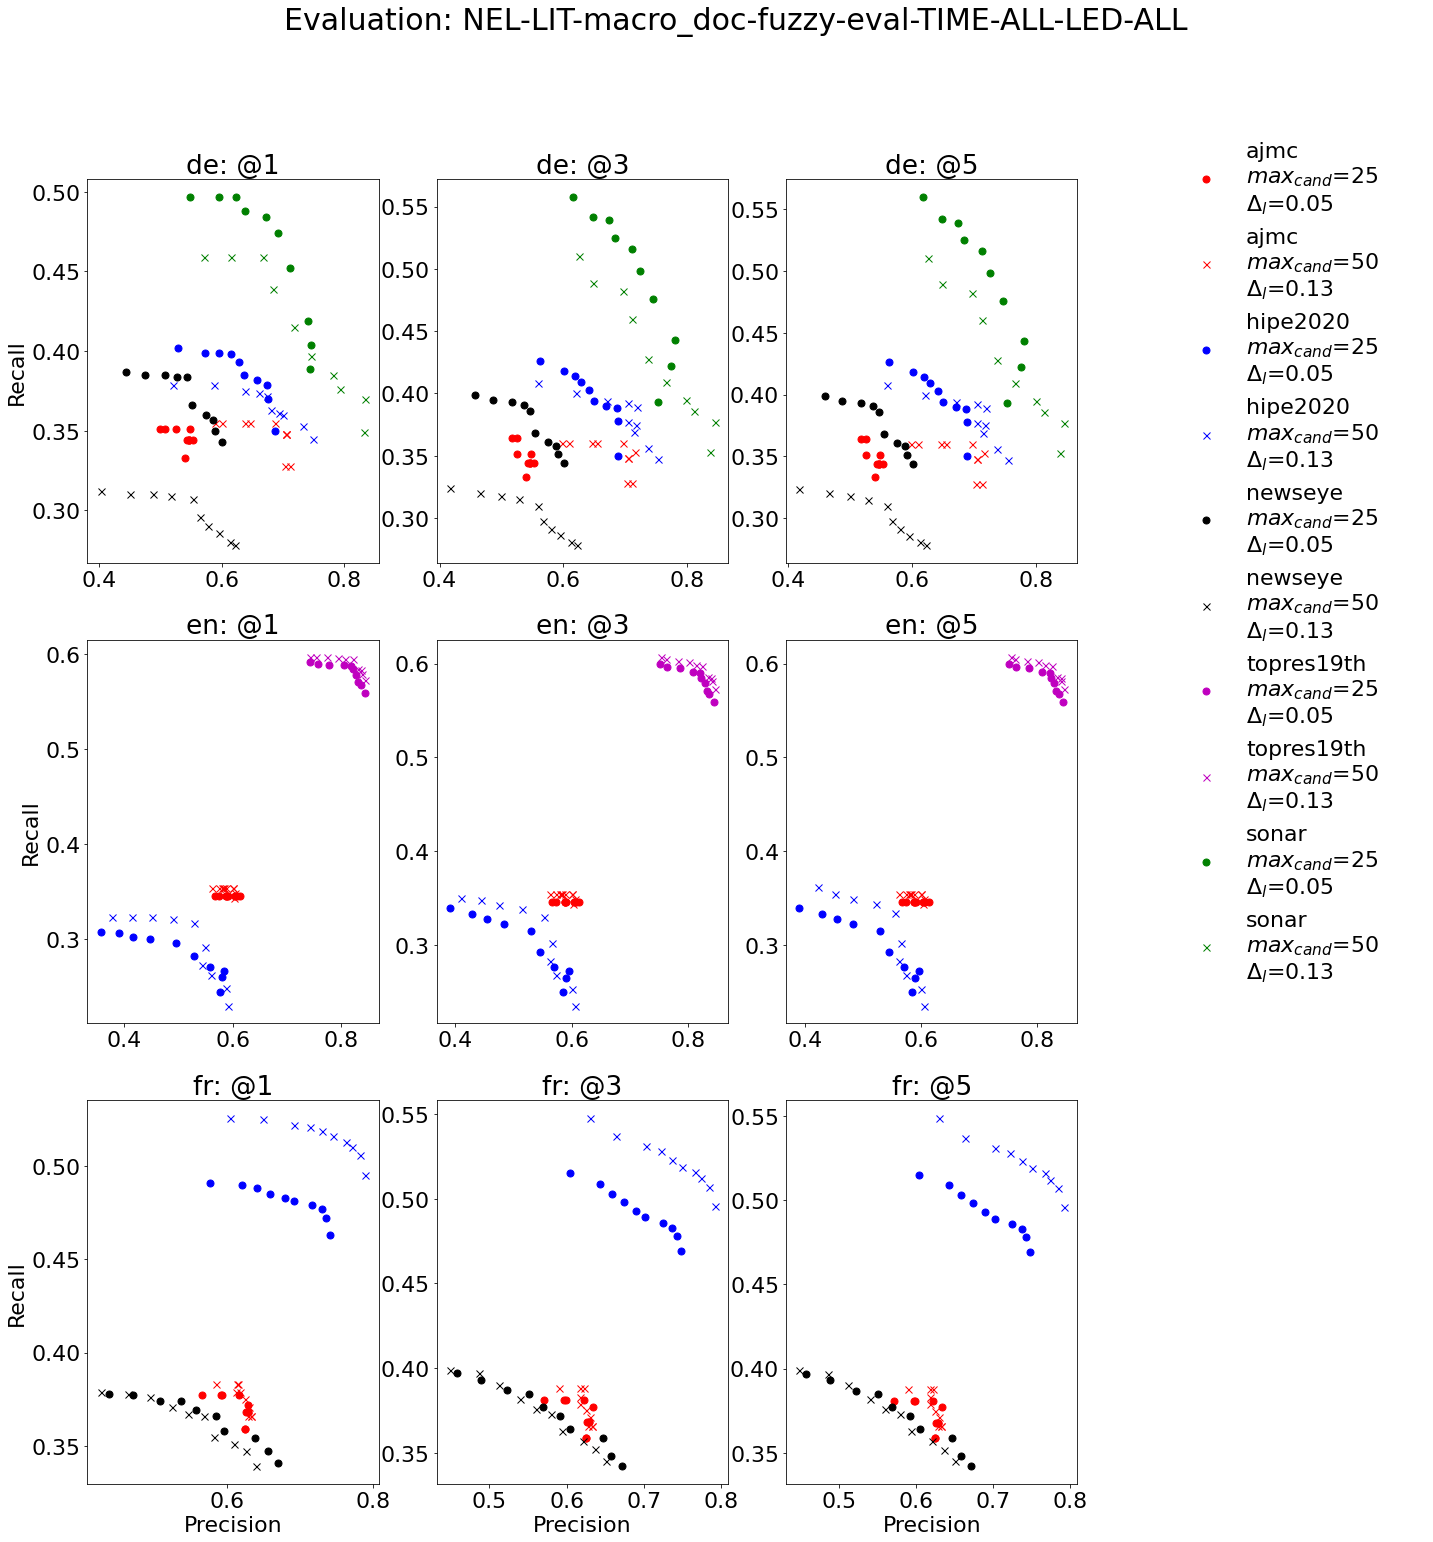

In [90]:
plot_lookup_influence('macro_doc-fuzzy', df_test)

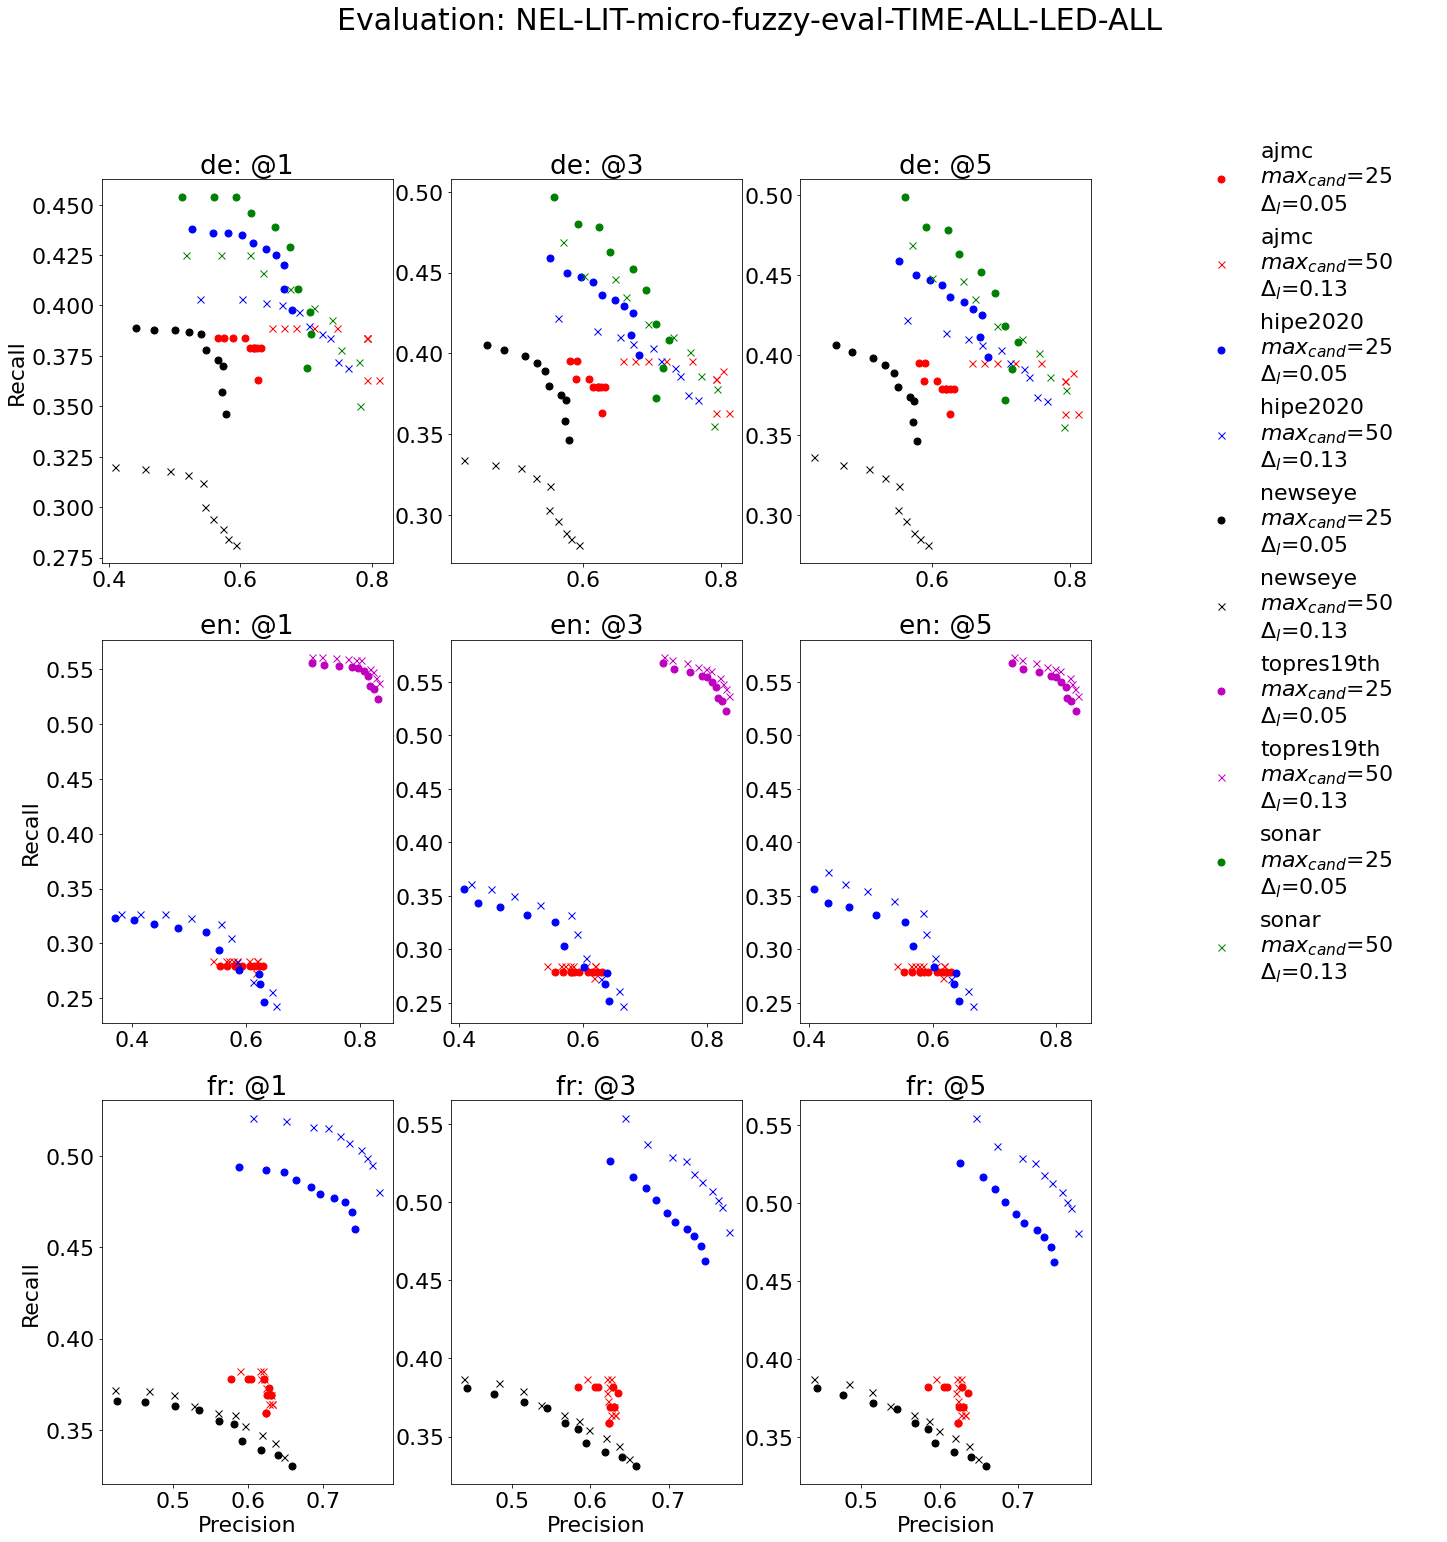

In [91]:
plot_lookup_influence('micro-fuzzy', df_test)